# Libraries

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

from IPython.display import Image

# Creating Spark Instance

In [2]:
conf = pyspark.SparkConf().setAll([
        ('spark.master',   'local[*]'),
        ('spark.app.name', 'PySpark Demo')])

# Schema for original data set
schema = StructType([StructField("YEAR", StringType(), False),
                        StructField("MONTH", StringType(), False),
                        StructField("DAY", StringType(), False),
                        StructField("DAY_OF_WEEK", StringType(), False),
                        StructField("AIRLINE", StringType(), False),
                        StructField("FLIGHT_NUMBER", StringType(), True),
                        StructField("TAIL_NUMBER", StringType(), True),
                        StructField("ORIGIN_AIRPORT", StringType(), False),
                        StructField("DESTINATION_AIRPORT", StringType(), False),
                        StructField("SCHEDULED_DEPARTURE", IntegerType(), False),
                        StructField("DEPARTURE_TIME", IntegerType(), True),
                        StructField("DEPARTURE_DELAY", IntegerType(), True),
                        StructField("TAXI_OUT", IntegerType(), True),
                        StructField("WHEELS_OFF", IntegerType(), True),
                        StructField("SCHEDULED_TIME", IntegerType(), True),
                        StructField("ELAPSED_TIME", IntegerType(), True),
                        StructField("AIR_TIME", IntegerType(), True),
                        StructField("DISTANCE", IntegerType(), True),
                        StructField("WHEELS_ON", IntegerType(), True),
                        StructField("TAXI_IN", IntegerType(), True),
                        StructField("SCHEDULED_ARRIVAL", IntegerType(), True),
                        StructField("ARRIVAL_TIME", IntegerType(), True),
                        StructField("ARRIVAL_DELAY", IntegerType(), True),
                        StructField("DIVERTED", StringType(), True),
                        StructField("CANCELLED", StringType(), True),
                        StructField("CANCELLATION_REASON", StringType(), True),
                        StructField("AIR_SYSTEM_DELAY", IntegerType(), True),
                        StructField("SECURITY_DELAY", IntegerType(), True),
                        StructField("AIRLINE_DELAY", IntegerType(), True),
                        StructField("LATE_AIRCRAFT_DELAY", IntegerType(), True),
                        StructField("WEATHER_DELAY", StringType(), True),
                    ])

# Importing Data

In [3]:
# Creating Spark session
spark = SparkSession.builder.config(conf=conf).getOrCreate()
df = spark.read.csv("flight-delays/flights.csv",
                            header=True,
                            schema = schema).cache()

22/04/28 01:30:31 WARN Utils: Your hostname, Carloss-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.225 instead (on interface en0)
22/04/28 01:30:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/28 01:30:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/28 01:30:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Data Schema

In [4]:
df.printSchema()

root
 |-- YEAR: string (nullable = true)
 |-- MONTH: string (nullable = true)
 |-- DAY: string (nullable = true)
 |-- DAY_OF_WEEK: string (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: string (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable 

In [5]:
df.show(2)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

In [6]:
# Top 5 airports with planes outbound
origin_airport_count = df.groupBy('ORIGIN_AIRPORT').count().orderBy('count', ascending=False)
origin_airport_count.show(5)

# Top 5 airports with planes inbound
destination_airport_count = df.groupBy('DESTINATION_AIRPORT').count().orderBy('count', ascending=False)
destination_airport_count.show(5)

+--------------+------+
|ORIGIN_AIRPORT| count|
+--------------+------+
|           ATL|346836|
|           ORD|285884|
|           DFW|239551|
|           DEN|196055|
|           LAX|194673|
+--------------+------+
only showing top 5 rows



+-------------------+------+
|DESTINATION_AIRPORT| count|
+-------------------+------+
|                ATL|346904|
|                ORD|285906|
|                DFW|239582|
|                DEN|196010|
|                LAX|194696|
+-------------------+------+
only showing top 5 rows



# Rendered EDA Images

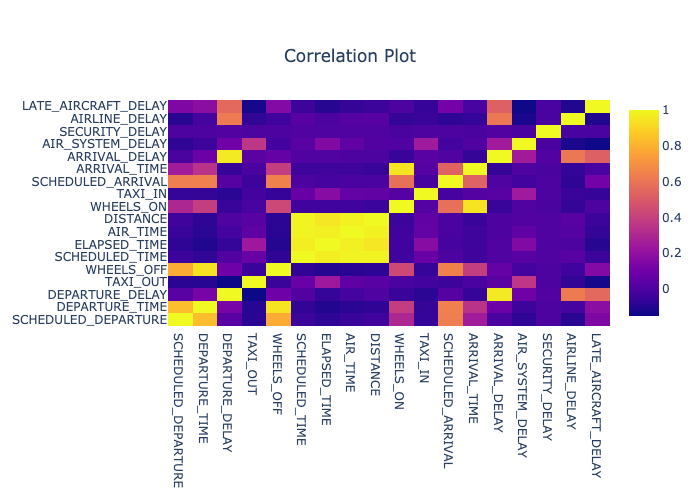

In [48]:
Image(filename="EDA_Static_Images/Correlation_Plot.png")

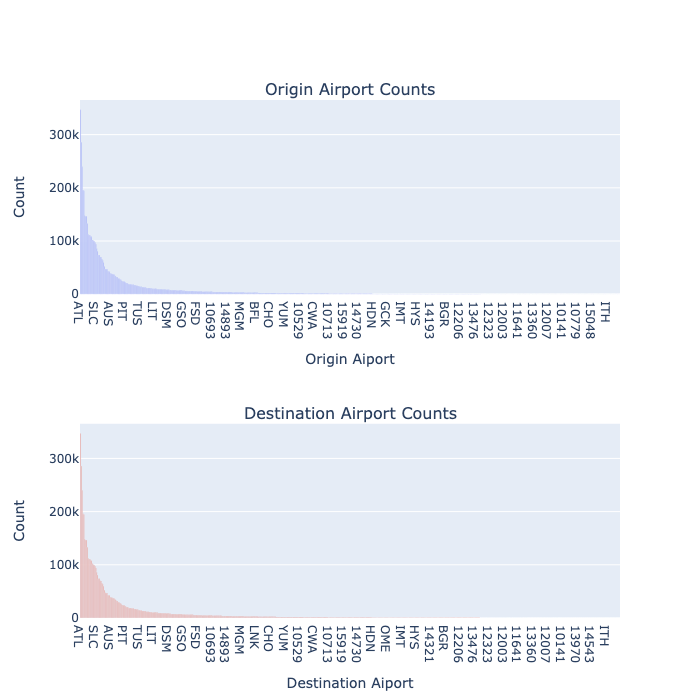

In [50]:
Image(filename="EDA_Static_Images/Origin_Destination_Airport_Count.png")

In [45]:
from IPython.display import IFrame
IFrame(src='EDA_HTML_Images/Correlation_Plot.html', width = 700, height = 700)